In [1]:
# Reproducibility
import random
random.seed(42)

from pathlib import Path
import sys
import os

RANDOM_SEED = 42

# Project root (folder that contains "data/")
PROJECT_ROOT = Path(r"C:\Users\tengc\Downloads\metrics-eval\metrics_eval")

# Input: issue tracking WhatsApp-style synthetic val set
INPUT_JSONL = PROJECT_ROOT / "data" / "issue_tracking" / "val" / "claude_48.jsonl"

# Output root
OUT_DIR = PROJECT_ROOT / "models" / "issue_tracking" / "results"
EXPERT_DIR = OUT_DIR / "expert_val"
EXPERT_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("INPUT_JSONL:", INPUT_JSONL)
print("INPUT exists:", INPUT_JSONL.exists())
print("OUT_DIR:", OUT_DIR)
print("EXPERT_DIR:", EXPERT_DIR)

PROJECT_ROOT: C:\Users\tengc\Downloads\metrics-eval\metrics_eval
INPUT_JSONL: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\data\issue_tracking\val\claude_48.jsonl
INPUT exists: True
OUT_DIR: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\issue_tracking\results
EXPERT_DIR: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\issue_tracking\results\expert_val


In [2]:
from dotenv import load_dotenv

ENV_PATH = PROJECT_ROOT.parent / ".env"  # you said: Loaded .env: C:\Users\tengc\Downloads\metrics-eval\.env

if ENV_PATH.exists():
    load_dotenv(dotenv_path=ENV_PATH)
    print(f"Loaded .env: {ENV_PATH}")
else:
    print("WARNING: .env not found at:", ENV_PATH)

print("OPENAI_API_KEY found:", bool(os.environ.get("OPENAI_API_KEY")))
print("ANTHROPIC_API_KEY found:", bool(os.environ.get("ANTHROPIC_API_KEY")))

Loaded .env: C:\Users\tengc\Downloads\metrics-eval\.env
OPENAI_API_KEY found: True
ANTHROPIC_API_KEY found: True


In [3]:
from dotenv import load_dotenv

ENV_PATH = PROJECT_ROOT.parent / ".env"  # you said: Loaded .env: C:\Users\tengc\Downloads\metrics-eval\.env

if ENV_PATH.exists():
    load_dotenv(dotenv_path=ENV_PATH)
    print(f"Loaded .env: {ENV_PATH}")
else:
    print("WARNING: .env not found at:", ENV_PATH)

print("OPENAI_API_KEY found:", bool(os.environ.get("OPENAI_API_KEY")))
print("ANTHROPIC_API_KEY found:", bool(os.environ.get("ANTHROPIC_API_KEY")))


Loaded .env: C:\Users\tengc\Downloads\metrics-eval\.env
OPENAI_API_KEY found: True
ANTHROPIC_API_KEY found: True


In [4]:
SCRIPTS_DIR = PROJECT_ROOT / "models" / "issue_tracking" / "scripts"
sys.path.append(str(SCRIPTS_DIR))

import pipeline
from export_issue_tracking_expert_sheet import export_workbook as export_issue_workbook

print("Imported pipeline from:", pipeline.__file__)


Imported pipeline from: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\issue_tracking\scripts\pipeline.py


In [6]:
GPT_MODEL = "gpt-5"
CLAUDE_MODEL = "claude-sonnet-4-5"

MODELS = [GPT_MODEL, CLAUDE_MODEL]

TEST_MODE = False        # set True for quick test
MAX_ROWS = 30            # only used if TEST_MODE=True
SLEEP_SEC = 0.0          # set small sleep if rate limits

print("MODELS:", MODELS)
print("TEST_MODE:", TEST_MODE)
print("MAX_ROWS:", MAX_ROWS)


MODELS: ['gpt-5', 'claude-sonnet-4-5']
TEST_MODE: False
MAX_ROWS: 30


In [7]:
from importlib import reload

# reload in case you edited scripts
reload(pipeline)

model_dfs = {}

for model_name in MODELS:
    model_out_dir = OUT_DIR / model_name.replace("/", "_")
    model_out_dir.mkdir(parents=True, exist_ok=True)

    print("\n========================================")
    print("Running model:", model_name)
    print("Saving to:", model_out_dir)

    df_out = pipeline.run_issue_tracking_pipeline(
        input_path=INPUT_JSONL,
        output_dir=model_out_dir,
        model=model_name,
        test_mode=TEST_MODE,
        max_rows=MAX_ROWS,
        sleep_sec=SLEEP_SEC,
    )
    model_dfs[model_name] = df_out

print("\nDone. Example rows:")
model_dfs[GPT_MODEL].head(3)



Running model: gpt-5
Saving to: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\issue_tracking\results\gpt-5
Reading input from: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\data\issue_tracking\val\claude_48.jsonl
[1/48] Processing message_id=WAM_001 ...
[2/48] Processing message_id=WAM_003 ...
[3/48] Processing message_id=WAM_005 ...
[4/48] Processing message_id=WAM_006 ...
[5/48] Processing message_id=WAM_008 ...
[6/48] Processing message_id=WAM_010 ...
[7/48] Processing message_id=WAM_011 ...
[8/48] Processing message_id=WAM_013 ...
[9/48] Processing message_id=WAM_015 ...
[10/48] Processing message_id=WAM_017 ...
[11/48] Processing message_id=WAM_018 ...
[12/48] Processing message_id=WAM_020 ...
[13/48] Processing message_id=WAM_022 ...
[14/48] Processing message_id=WAM_024 ...
[15/48] Processing message_id=WAM_026 ...
[16/48] Processing message_id=WAM_028 ...
[17/48] Processing message_id=WAM_029 ...
[18/48] Processing message_id=WAM_031 ...
[19/48] Processing mes

,chat_id,message_id,timestamp,sender_number,sender_name,message_text,model,raw_model_output,schema_ok,schema_bad_fields,...,customer,created_by,created_at,to_inform,assigned_to,resolved_at,status_to_close,closed_at,resolution_score,comments
0,65001,WAM_001,2024-11-12 14:23:45,6591234567,BRC Asia,"Hi good afternoon, may I know what time the go...",gpt-5,"{""issue"": ""Delivery Delay"", ""customer"": ""BRC A...",True,[],...,BRC Asia,Customer,2024-11-12 14:23:45,"AM, Cust Svc, Site",Cust Svc,,Cust Svc,,Not resolved yet,Customer asking ETA to site; check delivery sc...
1,65002,WAM_003,2024-11-13 09:15:33,6587654321,Hup Seng,Boss ask already — when can deliver? Urgent leh.,gpt-5,"{""issue"": ""Delivery Delay"", ""customer"": ""Hup S...",True,[],...,Hup Seng,Customer,2024-11-13 09:15:33,"AM, Cust Svc, Site",Cust Svc,,AM,,Not resolved yet,Customer asking for delivery ETA (urgent). Che...
2,65002,WAM_005,2024-11-13 09:30:12,6587654321,Hup Seng,Ok tks.,gpt-5,"{""issue"": ""Other"", ""customer"": ""Hup Seng"", ""cr...",True,[],...,Hup Seng,Customer,2024-11-13 09:30:12,,,,,,Not resolved yet,Acknowledgement only; no issue raised.


In [10]:
import pandas as pd

def load_model_csv(model_name: str) -> pd.DataFrame:
    model_dir = OUT_DIR / model_name.replace("/", "_")
    model_safe = model_name.replace("/", "_").replace(".", "_").replace("-", "_")
    csv_path = model_dir / f"issue_tracking_results_{model_safe}.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"Missing: {csv_path}")
    return pd.read_csv(csv_path)

dfs = {m: load_model_csv(m) for m in MODELS}
[(m, len(dfs[m])) for m in MODELS]


[('gpt-5', 48), ('claude-sonnet-4-5', 48)]

In [11]:
import numpy as np
import pandas as pd

def compute_nonexpert_metrics(df: pd.DataFrame) -> dict:
    n = len(df)
    if n == 0:
        return {"n_rows": 0}

    schema_ok_pct = round(float(df["schema_ok"].mean()) * 100, 2) if "schema_ok" in df.columns else 0.0

    # error is "" if ok
    err = df["error"].fillna("").astype(str).str.strip()
    error_rate_pct = round(float((err != "").mean()) * 100, 2)

    # basic field emptiness (sanity)
    issue_empty_pct = round(float((df["issue"].fillna("").astype(str).str.strip() == "").mean()) * 100, 2)
    assigned_empty_pct = round(float((df["assigned_to"].fillna("").astype(str).str.strip() == "").mean()) * 100, 2)

    comments_len = df["comments"].fillna("").astype(str).str.len()
    avg_comments_len = round(float(comments_len.mean()), 2)
    median_comments_len = float(comments_len.median())

    return {
        "n_rows": int(n),
        "schema_ok_pct": schema_ok_pct,
        "error_rate_pct": error_rate_pct,
        "issue_empty_pct": issue_empty_pct,
        "assigned_to_empty_pct": assigned_empty_pct,
        "avg_comments_len_chars": avg_comments_len,
        "median_comments_len_chars": median_comments_len,
    }

metrics_rows = []
for m in MODELS:
    met = compute_nonexpert_metrics(dfs[m])
    met["model"] = m
    metrics_rows.append(met)

metrics_df = pd.DataFrame(metrics_rows).sort_values("model")
metrics_df


,n_rows,schema_ok_pct,error_rate_pct,issue_empty_pct,assigned_to_empty_pct,avg_comments_len_chars,median_comments_len_chars,model
1,48,100.0,0.0,100.0,100.00,0.00,0.0,claude-sonnet-4-5
0,48,100.0,0.0,0.0,2.08,105.19,105.5,gpt-5


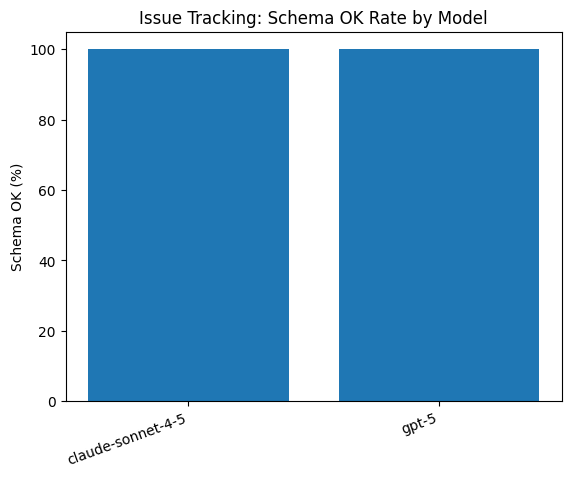

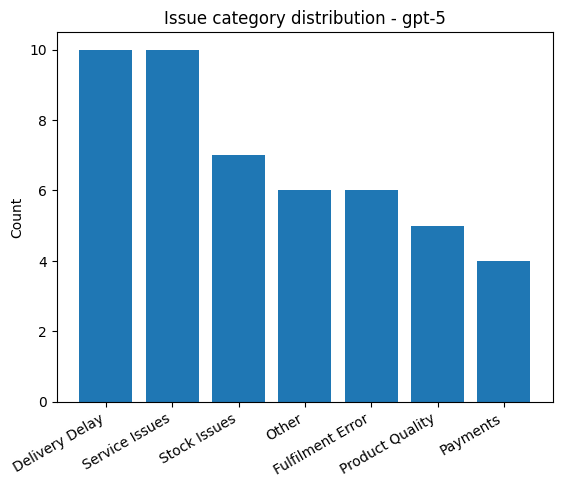

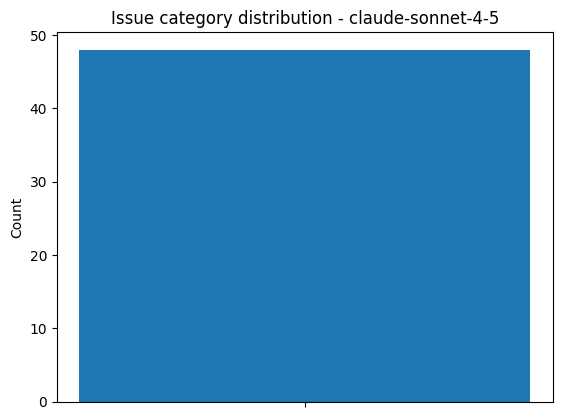

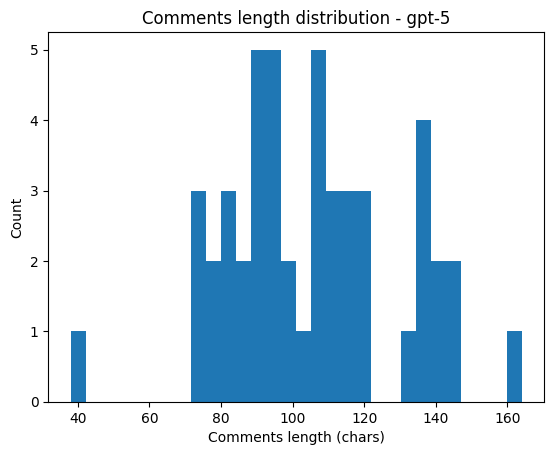

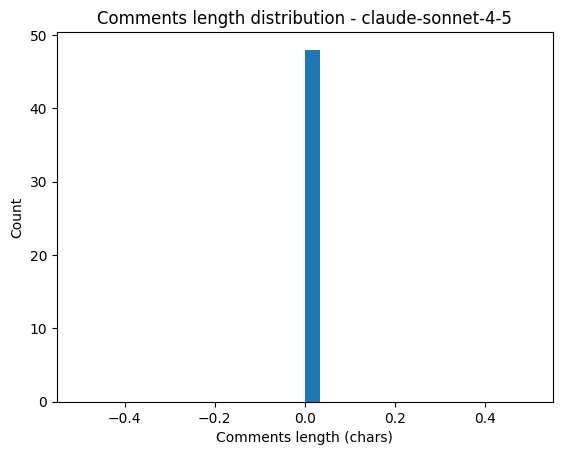

In [12]:
import matplotlib.pyplot as plt

# 1) Schema OK bar chart
plt.figure()
plt.bar(metrics_df["model"], metrics_df["schema_ok_pct"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("Schema OK (%)")
plt.title("Issue Tracking: Schema OK Rate by Model")
plt.show()

# 2) Issue category distribution (stacked-ish shown as separate bar charts)
for m in MODELS:
    df = dfs[m].copy()
    counts = df["issue"].fillna("").astype(str).value_counts()
    plt.figure()
    plt.bar(counts.index.astype(str), counts.values)
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Count")
    plt.title(f"Issue category distribution - {m}")
    plt.show()

# 3) Comments length histogram
for m in MODELS:
    lengths = dfs[m]["comments"].fillna("").astype(str).str.len()
    plt.figure()
    plt.hist(lengths, bins=30)
    plt.xlabel("Comments length (chars)")
    plt.ylabel("Count")
    plt.title(f"Comments length distribution - {m}")
    plt.show()


In [13]:
# Choose sample size per model for the client to validate
SAMPLE_N = 30

out_xlsx = EXPERT_DIR / "issue_tracking_expert_validation.xlsx"

export_issue_workbook(
    gpt_df=dfs[GPT_MODEL],
    claude_df=dfs[CLAUDE_MODEL],
    out_path=out_xlsx,
    sample_n=SAMPLE_N,
)

print("✅ Exported:", out_xlsx)


Saved: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\issue_tracking\results\expert_val\issue_tracking_expert_validation.xlsx
✅ Exported: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\issue_tracking\results\expert_val\issue_tracking_expert_validation.xlsx


In [14]:
metrics_csv = OUT_DIR / "nonexpert_metrics_issue_tracking.csv"
metrics_df.to_csv(metrics_csv, index=False)
print("Saved:", metrics_csv)


Saved: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\issue_tracking\results\nonexpert_metrics_issue_tracking.csv


In [15]:
from importlib import reload
import export_issue_tracking_expert_sheet as exp
reload(exp)

out_xlsx = EXPERT_DIR / "issue_tracking_expert_validation.xlsx"

exp.export_workbook(
    gpt_df=dfs[GPT_MODEL],
    claude_df=dfs[CLAUDE_MODEL],
    out_path=out_xlsx,
    sample_n=40,
)

print("✅ Exported:", out_xlsx)

Saved: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\issue_tracking\results\expert_val\issue_tracking_expert_validation.xlsx
✅ Exported: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\issue_tracking\results\expert_val\issue_tracking_expert_validation.xlsx
